# Machine Learning with SFE Dataset for Alloy Design

This notebook discusses the complete workflow for using SFE data of steels and doing visualization, learning with the training dataset and prediction on untested alloy compositions which could be potentially super useful in alloy design. Various statistical algorithms have been deployed for robust visualization and classification of the SFE dataset.

In [1]:
# Loading all required dependencies and packages

%matplotlib inline


import IPython
print("IPython: ", IPython.__version__)

import csv
print("csv: ", csv.__version__)

import pandas as pd
print("pandas: ", pd.__version__)

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib: ", matplotlib.__version__)

import numpy as np
print("numpy: ", np.__version__)

import sklearn
print("Scikit Learn: ", sklearn.__version__)
import math
import pylab
import time
import pprint as pp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter


('IPython: ', '4.0.2')
('csv: ', '1.0')
('pandas: ', u'0.17.1')
('matplotlib: ', '1.5.0')
('numpy: ', '1.10.1')
('Scikit Learn: ', '0.17')


##### ini_dataset is the first as-is load of the 'Final.csv'

In [2]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 300

ini_dataset = pd.read_csv('Final.csv', delimiter =',',index_col = None, header = 0)
colheaders = list(ini_dataset.columns.values)

print ini_dataset.head(2)
print "\n"
print colheaders

       C      N      P      S  V    Ni  Nb  Al  Ti      Fe  Hf   Mo    Mn  Co  \
0  0.004  0.003  0.025  0.001  0  15.6   0   0   0  64.317   0  2.5  0.03   0   
1  0.020  0.009  0.022  0.001  0  15.6   0   0   0  64.188   0  2.5  0.03   0   

     Si    Cr  Cu                        DOI  \
0  0.02  17.5   0  10.1007/s11661-013-1943-0   
1  0.03  17.6   0  10.1007/s11661-013-1943-0   

                                                 url   SFE     Error  \
0  http://link.springer.com/article/10.1007/s1166...  51.6  0.014341   
1  http://link.springer.com/article/10.1007/s1166...  54.6  0.023810   

                                               title            Author  \
0  The Effect of Chemical Composition and Heat Tr...  Yonezawa, Toshio   
1  The Effect of Chemical Composition and Heat Tr...  Yonezawa, Toshio   

   temperature experiment_type  
0          300      TEM - WBDF  
1          300      TEM - WBDF  


['C', 'N', 'P', 'S', 'V', 'Ni', 'Nb', 'Al', 'Ti', 'Fe', 'Hf', 'Mo', 'M

## Data Pre-processing

Below we will load all the SFE data from the csv file and then choose predictors which have enough data points to qualify as predictors

##### ini_dataset_1 is the next subset of dataset with only room temperature measurements

In [3]:
print "There are total %d observations in the dataset" %len(ini_dataset)

print "There are total %d observations in the dataset that are room temperature measurements"% \
len(ini_dataset[(ini_dataset.temperature>290) & (ini_dataset.temperature<310)])

ini_dataset_1 = ini_dataset[(ini_dataset.temperature>290) & (ini_dataset.temperature<310)]

print "There are total %d observations in the room temp dataset" %len(ini_dataset_1)

There are total 473 observations in the dataset
There are total 426 observations in the dataset that are room temperature measurements
There are total 426 observations in the room temp dataset


In [4]:
print ini_dataset_1.experiment_type.unique()

['TEM - WBDF' 'XRD' 'TEM' 'Thermodynamic Modeling' 'Synchrotron XRD'
 'TEM-WBDF' 'Neutron Diffraction' 'Literature Review' 'Literature review']


In [5]:
len(ini_dataset_1[ini_dataset_1.experiment_type != 'Thermodynamic Modeling'])

387

##### ini_dataset_2 is the next subset of dataset with only experimental values

In [6]:
ini_dataset_2 = ini_dataset_1[ini_dataset_1.experiment_type != 'Thermodynamic Modeling']
print len(ini_dataset_2)
print ini_dataset_2.columns.values
print len(ini_dataset_2.columns.values)
print ini_dataset_2.columns[[17,18]]

387
['C' 'N' 'P' 'S' 'V' 'Ni' 'Nb' 'Al' 'Ti' 'Fe' 'Hf' 'Mo' 'Mn' 'Co' 'Si' 'Cr'
 'Cu' 'DOI' 'url' 'SFE' 'Error' 'title' 'Author' 'temperature'
 'experiment_type']
25
Index([u'DOI', u'url'], dtype='object')


In [7]:
ini_dataset_2 = ini_dataset_2.drop(['DOI','url'],axis=1)
print ini_dataset_2.columns.values
print len(ini_dataset_2.columns.values)

['C' 'N' 'P' 'S' 'V' 'Ni' 'Nb' 'Al' 'Ti' 'Fe' 'Hf' 'Mo' 'Mn' 'Co' 'Si' 'Cr'
 'Cu' 'SFE' 'Error' 'title' 'Author' 'temperature' 'experiment_type']
23


##### ini_dataset_3 is the next subset of dataset with only ferrous alloys

In [8]:
print len(ini_dataset_2)
print len(ini_dataset_2[ini_dataset_2.Author != 'Unfried-Silgado, Jimy'])

ini_dataset_3 = ini_dataset_2[ini_dataset_2.Author != 'Unfried-Silgado, Jimy']
print len (ini_dataset_3)

387
379
379


In [9]:
colheaders_2 = ['C','N','P','S','V','Ni','Nb','Mn','Al','Ti','Fe','Hf','Mo','Co','Si','Cr','Cu']
for item in colheaders_2 :
    print  item, len(ini_dataset_3[ini_dataset_3[item] > 0.05])


C 98
N 85
P 7
S 1
V 0
Ni 300
Nb 2
Mn 217
Al 27
Ti 0
Fe 379
Hf 0
Mo 133
Co 3
Si 120
Cr 332
Cu 6


In [10]:
colheaders_3 = ['Nb','Co','Cu']
for item in colheaders_3 :
    print  item, len(ini_dataset_3[ini_dataset_3[item] > 0.05])


Nb 2
Co 3
Cu 6


In [11]:
ini_dataset_3[(ini_dataset_3.Nb> 0.1) | (ini_dataset_3.Co> 0.1) | (ini_dataset_3.Cu>0.1)][[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,]]

,C,N,P,S,V,Ni,Nb,Al,Ti,Fe,Hf,Mo,Mn,Co,Si,Cr,Cu,SFE,Error,Author
117,0.047,0.205,0.00,0.000,0,3.71,0.00,0,0,71.218,0,0.05,6.74,0.00,0.32,17.48,0.23,13.20,0.000000,"Barman, H."
132,0.047,0.205,0.00,0.000,0,3.71,0.00,0,0,71.218,0,0.05,6.74,0.00,0.32,17.48,0.23,15.84,0.000000,"Barman, H."
237,0.041,0.054,0.00,0.000,0,8.10,0.00,0,0,70.875,0,0.32,1.71,0.00,0.33,18.20,0.37,17.80,0.067416,"Talonen, J."
238,0.019,0.094,0.00,0.000,0,6.60,0.00,0,0,73.237,0,0.14,1.61,0.00,0.48,17.60,0.22,12.80,0.117188,"Talonen, J."
239,0.017,0.145,0.00,0.000,0,6.60,0.00,0,0,73.698,0,0.15,1.34,0.00,0.51,17.40,0.14,14.70,0.054422,"Talonen, J."
256,0.023,0.000,0.00,0.000,0,8.59,0.00,0,0,66.667,0,0.00,0.15,6.42,0.19,17.96,0.00,11.50,0.000000,"Dulieu, D."
257,0.115,0.000,0.00,0.000,0,10.04,0.00,0,0,66.525,0,0.00,0.22,0.00,0.10,17.80,5.20,63.25,0.090900,"Dulieu, D."
335,0.006,0.007,0.01,0.014,0,15.00,0.00,0,0,49.420,0,0.00,0.04,20.20,0.00,15.30,0.00,27.60,0.000000,"Silcock, J.M."
339,0.000,0.000,0.00,0.000,0,10.10,0.00,0,0,64.350,0,0.00,0.00,9.55,0.00,16.00,0.00,18.40,0.000000,"Silcock, J.M."
351,0.014,0.004,0.00,0.000,0,20.00,1.00,0,0,58.982,0,0.00,0.00,0.00,0.00,20.00,0.00,17.25,0.000000,"Douglass, D.L."


##### ini_dataset_4 is the next subset of dataset with only values along the 9 chosen elements with enough datapoints

In [12]:
ini_dataset_4 = ini_dataset_3[(ini_dataset_3.Nb< 1) & (ini_dataset_3.Co< 1) & (ini_dataset_3.Cu< 1)]
len(ini_dataset_4)

374

In [13]:
ini_dataset_4 = ini_dataset_4.drop(['P','S','V','Ti','Hf','Nb','Co','Cu'],axis=1)
print ini_dataset_4.columns.values
print len(ini_dataset_4.columns.values)

['C' 'N' 'Ni' 'Al' 'Fe' 'Mo' 'Mn' 'Si' 'Cr' 'SFE' 'Error' 'title' 'Author'
 'temperature' 'experiment_type']
15


In [14]:
index = range(1,375)
ini_dataset_5 = ini_dataset_4
print len(ini_dataset_5)
ini_dataset_5.insert(0,'sno',index)


374


In [15]:
ini_dataset_5 = ini_dataset_5.set_index(['sno'])
ini_dataset_5.head()

,C,N,Ni,Al,Fe,Mo,Mn,Si,Cr,SFE,Error,title,Author,temperature,experiment_type
sno,,,,,,,,,,,,,,,
1,0.004,0.003,15.6,0,64.317,2.5,0.03,0.02,17.5,51.6,0.014341,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF
2,0.020,0.009,15.6,0,64.188,2.5,0.03,0.03,17.6,54.6,0.023810,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF
3,0.020,0.002,14.0,0,66.409,2.4,0.03,0.01,17.1,50.3,0.023062,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF
4,0.005,0.001,15.6,0,63.866,2.6,0.19,0.01,17.7,52.8,0.012879,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF
5,0.016,0.008,10.8,0,68.899,0.3,0.85,0.10,19.0,35.0,0.023429,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF


##### Converting dataframe to array

In [16]:
ini_array = ini_dataset_5.reset_index().values
print ini_array.shape
SFEdata = ini_array[:,0:12]
SFEdata = np.array(SFEdata, dtype='float')
low = SFEdata[:,10]*(1 - SFEdata[:,11])
high = SFEdata[:,10]*(1 + SFEdata[:,11])
lowhigh = np.column_stack((low,high))

(374L, 16L)


In [17]:
SFEdata = np.column_stack((SFEdata,lowhigh))
SFEdata.shape

(374L, 14L)

In [18]:
SFEdata[244,9] = 18
SFEdata[244,5] = 74
SFEdata[244,]

array([ 245.,    0.,    0.,    8.,    0.,   74.,    0.,    0.,    0.,
         18.,   16.,    0.,   16.,   16.])

In [44]:
#determining class based on SFE value

SFEclass = np.zeros(SFEdata.shape[0])

SFEclass[SFEdata[:,10] <= 20] = 1
SFEclass[(SFEdata[:,10] > 20) & (SFEdata[:,10] <= 45)] = 2
SFEclass[(SFEdata[:,10] > 45)] = 3

#check number of entries for each class 
print((SFEclass == 1).sum())
print((SFEclass == 2).sum())
print((SFEclass == 3).sum())

#check if only the needed classes there
print (SFEclass == 1).sum() + (SFEclass == 2).sum() + (SFEclass == 3).sum() 
print SFEclass.shape
print SFEdata.shape

77
209
88
374
(374L,)
(374L, 14L)


In [21]:
#determining alternate class based on SFE value

SFEclass2 = np.zeros(SFEdata.shape[0])

SFEclass2[SFEdata[:,10] <= 16] = 1
SFEclass2[((SFEdata[:,10] > 16) & (SFEdata[:,10] <= 24))] = 4
SFEclass2[(SFEdata[:,10] > 24) & (SFEdata[:,10] <= 41)] = 2
SFEclass2[((SFEdata[:,10] > 41) & (SFEdata[:,10] <= 49))] = 5
SFEclass2[(SFEdata[:,10] > 49)] = 3


#check number of entries for each class 
print((SFEclass2 == 1).sum())
print((SFEclass2 == 2).sum())
print((SFEclass2 == 3).sum())
print((SFEclass2 == 4).sum())
print((SFEclass2 == 5).sum())

#check if only the needed classes there
print (SFEclass2 == 1).sum() + (SFEclass2 == 2).sum() + (SFEclass2 == 3).sum() + (SFEclass2 == 4).sum() + (SFEclass2 == 5).sum()
print SFEclass2.shape
print SFEdata.shape

48
129
64
57
76
374
(374L,)
(374L, 14L)


In [22]:
Elements = SFEdata[:,:10]
print Elements.shape
Elementlist=ini_dataset_5.columns.values[0:9]
print Elementlist
print SFEclass.shape, SFEclass2.shape

(374L, 10L)
['C' 'N' 'Ni' 'Al' 'Fe' 'Mo' 'Mn' 'Si' 'Cr']
(374L,) (374L,)


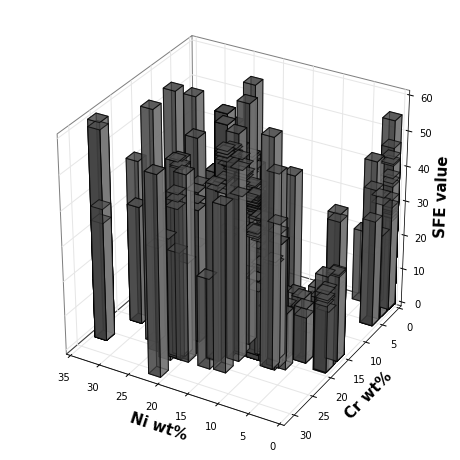

In [23]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.bar3d(SFEdata[SFEdata[:,10]<70,3],SFEdata[SFEdata[:,10]<70,9],
         np.zeros(SFEdata[SFEdata[:,10]<70,:].shape[0]),2,2,SFEdata[SFEdata[:,10]<70,10],
         edgecolor='black', color='grey', alpha=0.7)
ax.set_xlabel("Ni wt%", fontsize=15, fontweight='heavy')
ax.set_xlim(35,0)
ax.set_ylabel("Cr wt%", fontsize=15, fontweight='heavy')
ax.set_ylim(32,0)
ax.set_zlabel("SFE value", fontsize=15, fontweight='heavy')
ax.set_zlim(0,60)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

#ax.view_init(15,120)

plt.savefig('Ni-Cr.png',format='png',dpi=500)

In [24]:
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

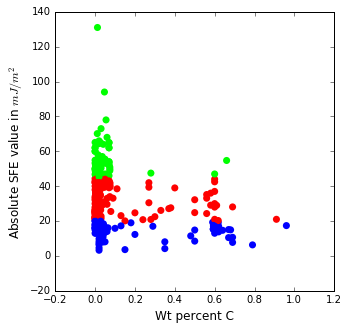

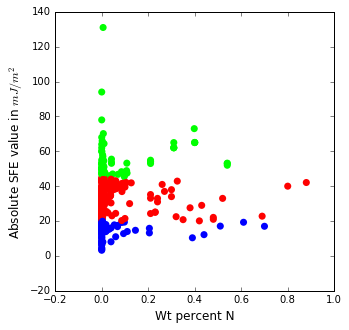

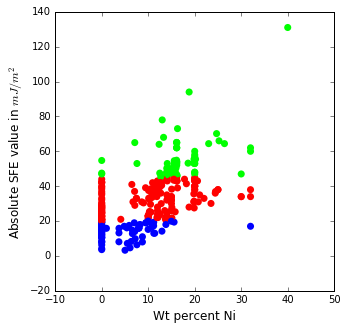

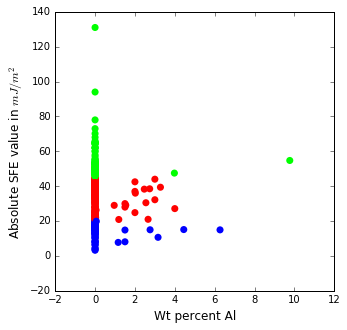

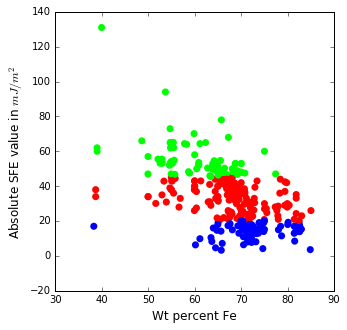

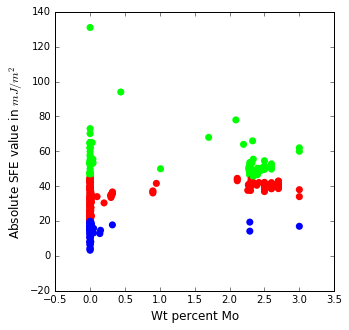

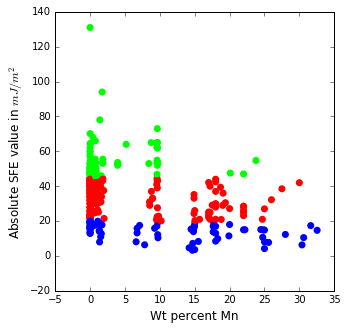

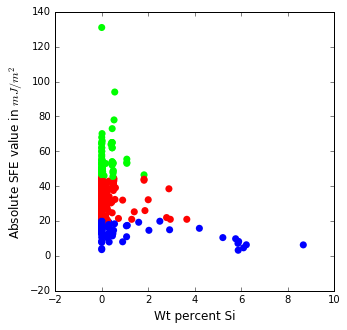

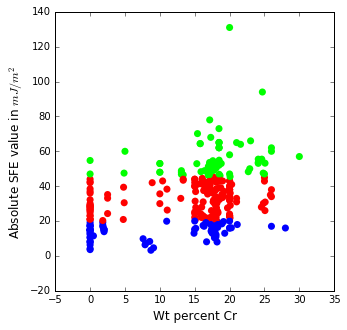

In [54]:
for i in range(1,10):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(Elements[:,i],SFEdata[:,10],c=SFEclass,marker="o", s=50, edgecolor='',cmap ='brg')
    ax.set_xlabel("Wt percent %s"%Elementlist[i-1],fontsize=12, fontweight='normal')
    ax.set_ylabel("Absolute SFE value in $mJ/m^2$",fontsize=12, fontweight='normal')
#    ax.set_title("SFE variation with %s"%Elementlist[i-1], fontweight='bold', fontsize=15, fontname='Segoe UI')
    plt.savefig("Figure1_{y}.png".format(y=Elementlist[i-1]),dpi=500)

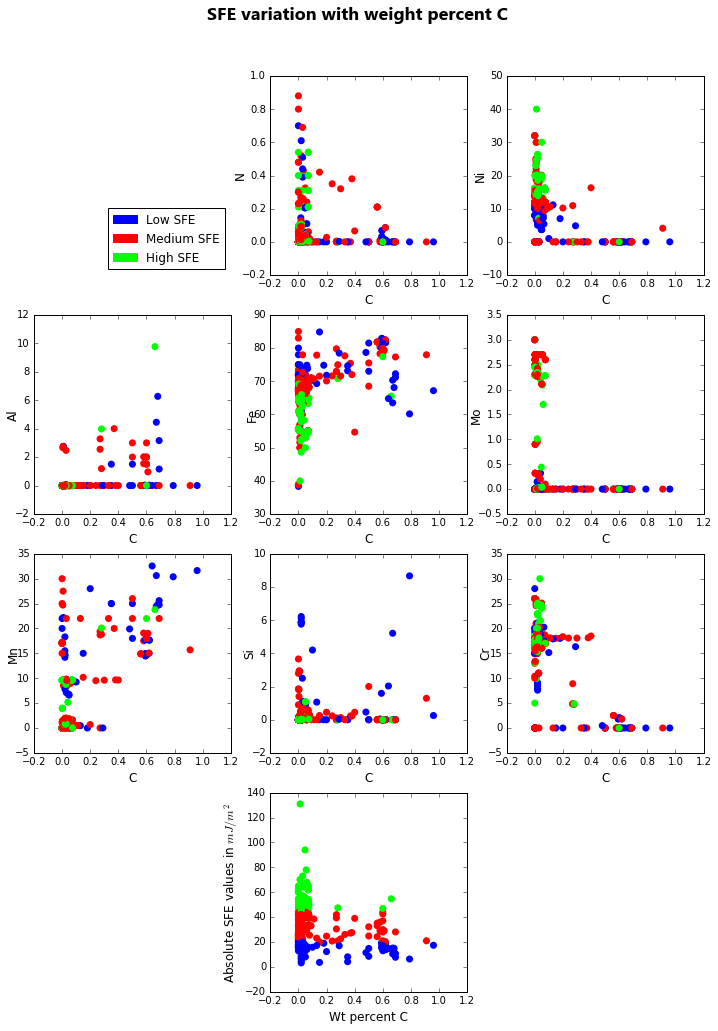

In [51]:
iterarr1= range(1,2)
iterarr = range(1,10)
for j in iterarr1:
    fig = plt.figure(figsize=(12,16))
    fig.suptitle("SFE variation with weight percent %s"%Elementlist[j-1], fontweight='bold', fontsize=18, fontname='Segoe UI')
    plt.subplots_adjust(top=.92)
    for i in iterarr:
        ax = fig.add_subplot(4,3,i)
        if (i!=j):
            cax = ax.scatter(Elements[:,j],Elements[:,i], c=SFEclass, marker="o", s=50, edgecolor='', cmap ='brg')
            ax.set_xlabel(Elementlist[j-1],fontsize=12, fontweight='normal')
            ax.xaxis.labelpad = 5
            ax.set_ylabel(Elementlist[i-1],fontsize=12, fontweight='normal')
            ax.yaxis.labelpad = -5
        else:
            #fig.colorbar(cax)
            blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
            red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
            green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')
            plt.axis('off')
            ax.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower right')
    ax = fig.add_subplot(4,3,11)        
    ax.scatter(Elements[:,j],SFEdata[:,10], c=SFEclass, marker="o", s=50, edgecolor='', cmap ='brg')
    ax.set_xlabel("Wt percent %s"%Elementlist[j-1],fontsize=12, fontweight='normal')
    ax.set_ylabel("Absolute SFE values in $mJ/m^2$",fontsize=12, fontweight='normal')
    plt.savefig("Figure1_{y}.png".format(y=Elementlist[j-1]),dpi=500)

In [25]:
#sandbox cell for checking values of interest
ini_dataset_5[(ini_dataset_5.Mo > 2)&(ini_dataset_5.SFE < 20)]

,C,N,Ni,Al,Fe,Mo,Mn,Si,Cr,SFE,Error,title,Author,temperature,experiment_type
sno,,,,,,,,,,,,,,,
55,0.015,0.0193,12.95,0,65.6457,2.29,1.3,0.43,17.35,14.2,0,Weak Beam TEM Study on Stacking Fault Energy o...,"Ojima, M.",300,TEM
66,0.000,0.7000,32.00,0,38.3000,3.00,0.0,0.00,26.00,17.0,0,Orientation dependence of resolved shear stres...,"Kireeva, I. V.",300,TEM


In [26]:
def arraynorm(array,axis):
    minaxis = np.nanmin(array,axis)
    maxaxis = np.nanmax(array,axis)
    diffaxis = maxaxis - minaxis
    output = np.true_divide(array-minaxis,diffaxis)
    return output

def arraystandardize(array,axis):
    meanaxis = np.mean(array,axis)
    stdaxis = np.std(array,axis)
    output = np.true_divide(array-meanaxis,stdaxis)
    return output

In [27]:
NormElements = arraynorm(Elements[:,1:],0)
StdElements = arraystandardize(Elements[:,1:],0)

In [28]:
SFEclassint = np.array(SFEclass, dtype='int')

explained variance ratio (first two components): [ 0.52334515  0.24176849  0.08024311]
total variance explained(first two components): 0.845356750673


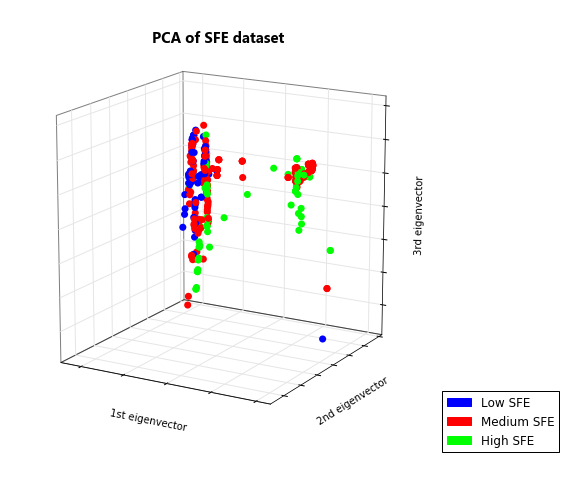

In [59]:
#PCA

from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(NormElements)

pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(NormElements)
var = math.floor(sum(pca_3.explained_variance_ratio_)*100)

print 'explained variance ratio (first two components): %s' % str(pca_3.explained_variance_ratio_)
print  'total variance explained(first two components): %s' %sum(pca_3.explained_variance_ratio_)

my_labels = ['Low SFE', 'Medium SFE', 'High SFE']



fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(1, 2,width_ratios=[10,2])
ax1 = plt.subplot(gs[0], projection='3d')
ax2 = plt.subplot(gs[1])


cax= ax1.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], s=50, c=SFEclass ,  edgecolor='', cmap='brg', depthshade=False)
#for i in range(0,len(X_pca_3)):
#    ax.text(X_pca_3[i,0], X_pca_3[i,1], X_pca_3[i,2],  '%s' % (str(i)), size=10 ,zorder=1, color='y') 
ax1.set_title("PCA of SFE dataset", fontweight='bold', fontsize=15, fontname='Segoe UI')
ax1.set_xlabel("1st eigenvector")
ax1.set_xlim(X_pca_3[:,0].min()-0.1,X_pca_3[:,0].max()+0.1)
ax1.w_xaxis.set_ticklabels([])
ax1.set_ylabel("2nd eigenvector")
ax1.set_ylim(X_pca_3[:,1].min()-0.1,X_pca_3[:,1].max()+0.1)
ax1.w_yaxis.set_ticklabels([])
ax1.set_zlabel("3rd eigenvector")
ax1.set_zlim(X_pca_3[:,2].min()-0.1,X_pca_3[:,2].max()+0.1)
ax1.w_zaxis.set_ticklabels([])
ax1.view_init(15,120)
ax1.xaxis.pane.set_edgecolor('black')
ax1.yaxis.pane.set_edgecolor('black')
ax1.zaxis.pane.set_edgecolor('black')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
#fig.colorbar(cax)
blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')
plt.axis('off')
ax2.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower right')

#plt.savefig('PCA3.png',format='png',dpi=500,bbox_inches='tight')
plt.show()


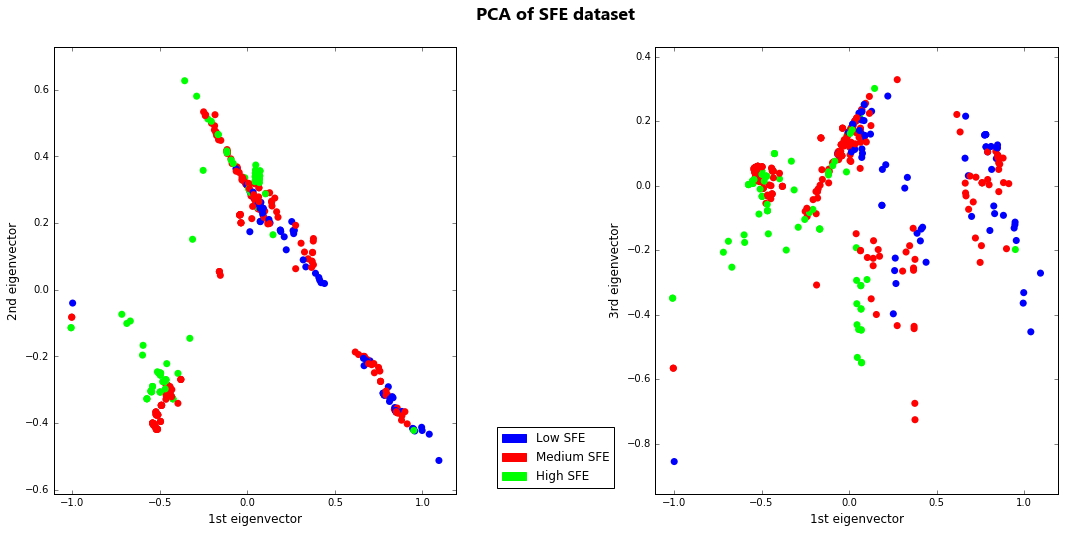

<function matplotlib.pyplot.close>

In [60]:


fig = plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(1, 3,width_ratios=[10,2,10])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1],frameon=False)
ax3 = plt.subplot(gs[2])

ax1.scatter(X_pca_3[:, 0], X_pca_3[:, 1], s=50, c=SFEclass, cmap='brg', edgecolor='')
#ax1.set_title("PCA of SFE dataset", fontweight='bold', fontsize=15, fontname='Segoe UI')
ax1.set_xlabel("1st eigenvector", fontsize=12)
ax1.set_xlim(X_pca_3[:,0].min()-0.1,X_pca_3[:,0].max()+0.1)
#ax1.xaxis.set_ticklabels([])
ax1.set_ylabel("2nd eigenvector", fontsize=12)
ax1.set_ylim(X_pca_3[:,1].min()-0.1,X_pca_3[:,1].max()+0.1)
#ax1.yaxis.set_ticklabels([])

ax3.scatter(X_pca_3[:, 0], X_pca_3[:, 2], s=50, c=SFEclass, cmap='brg', edgecolor='')
#ax3.set_title("PCA of SFE dataset", fontweight='bold', fontsize=15, fontname='Segoe UI')
ax3.set_xlabel("1st eigenvector", fontsize=12)
ax3.set_xlim(X_pca_3[:,0].min()-0.1,X_pca_3[:,0].max()+0.1)
#ax3.xaxis.set_ticklabels([])
ax3.set_ylabel("3rd eigenvector", fontsize=12)
ax3.set_ylim(X_pca_3[:,2].min()-0.1,X_pca_3[:,2].max()+0.1)
#ax3.yaxis.set_ticklabels([])

blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')

ax2.set_title("PCA of SFE dataset", fontweight='heavy', fontsize=18, fontname='Segoe UI')
ax2.title.set_position([0.5,1.05])
ax2.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower center')
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
#plt.axis('off')

#plt.savefig('PCA2.png',dpi=500)
plt.show()
plt.close

In [93]:
## sandbox cell for checking values from PCA
checkarray = np.where((X_pca_3[:,0]>0.1))
print checkarray
print ini_dataset_5.iloc[checkarray]
print X_pca_3[244,:]

(array([  0,   1,   2,   3,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  23,  24,  25,  26,  27,  28,  29,
        31,  32,  50,  54,  63,  64,  65,  70,  73,  74,  79,  82,  84,
       157, 167, 168, 230, 244, 256, 257, 260, 268, 270, 274, 275, 279,
       281, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
       296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308,
       309, 310, 311, 312, 313, 314, 315, 316, 318, 319, 320, 321, 322,
       323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335,
       336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348,
       349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,
       362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372], dtype=int64),)
          C       N     Ni  Al       Fe    Mo     Mn     Si     Cr     SFE  \
sno                                                                          
1    0.0040  0.0030  15.60   0  64.3170  2.50

In [111]:
#sandbox cell for checking values from PCA
checkarray = np.where((X_pca_3[:,0]<-0.5))
print checkarray
print ini_dataset_5.iloc[checkarray]
print X_pca_3[88,:]

(array([ 33,  34,  35,  36,  37,  51,  52,  53,  85,  86,  87,  88,  94,
        95,  96, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 173, 174, 175, 176, 189, 190, 191, 192, 193,
       194, 210, 211, 212, 213, 231, 232, 261, 272, 273, 283, 373], dtype=int64),)
          C      N   Ni    Al       Fe  Mo     Mn    Si    Cr     SFE  \
sno                                                                     
34   0.6900  0.000  0.0  1.16  72.2500   0  25.59  0.00  0.00   7.750   
35   0.6900  0.000  0.0  3.16  71.1800   0  24.75  0.00  0.00  10.670   
36   0.6700  0.000  0.0  4.45  70.3100   0  24.47  0.00  0.00  15.120   
37   0.6800  0.000  0.0  6.27  68.1000   0  24.80  0.00  0.00  14.950   
38   0.6600  0.000  0.0  9.77  65.5400   0  23.78  0.00  0.00  54.740   
52   0.0093  0.000  0.0  2.76  72.1107   0  22.20  2.92  0.00  15.000   
53   0.0053  0.000  0.0  2.66  69.6847   0  

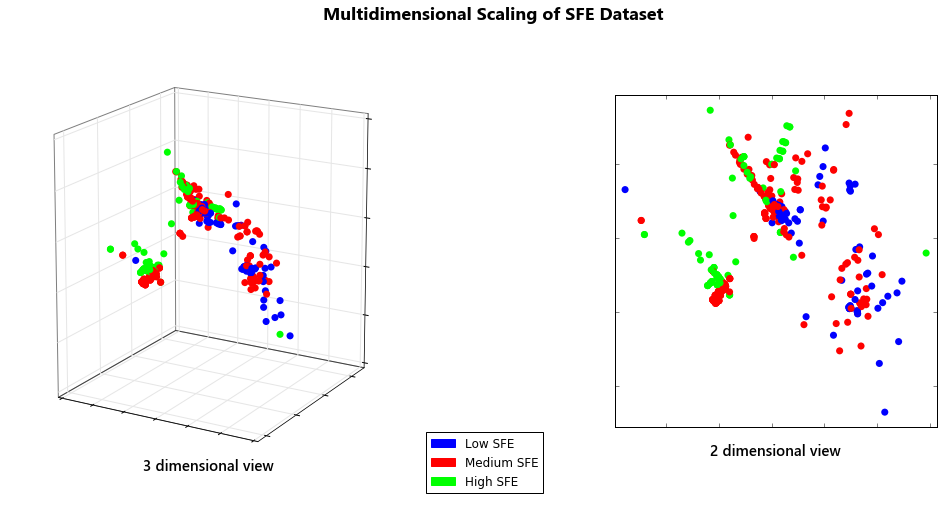

In [61]:
from sklearn import manifold


mds3Norm = manifold.MDS(n_components=3, eps = 1e-6, n_init = 3, random_state = 20)
mds3NormY = mds3Norm.fit_transform(NormElements)

mds2Norm = manifold.MDS(n_components=2, eps = 1e-6, n_init = 3, random_state = 20)
mds2NormY = mds2Norm.fit_transform(NormElements)

fig = plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(20, 5,width_ratios=[10,2,.5,8,1])
fig.suptitle("Multidimensional Scaling of SFE Dataset", fontweight='bold', fontsize=18, fontname='Segoe UI')
plt.subplots_adjust(top=.95)

ax1 = plt.subplot(gs[:20,0], projection='3d')
ax2 = plt.subplot(gs[:20,1],frameon=False)
ax3 = plt.subplot(gs[3:17,3])

ax1.scatter( mds3NormY[:, 0], mds3NormY[:, 1], mds3NormY[:, 2], c = SFEclass, s =50,  edgecolor='', depthshade=False, cmap='brg')
ax1.set_title("3 dimensional view", fontweight='normal', fontsize=15, fontname='Segoe UI')
ax1.title.set_position([0.5,0.05])
ax1.xaxis.set_major_formatter(NullFormatter())
ax1.yaxis.set_major_formatter(NullFormatter())
ax1.zaxis.set_major_formatter(NullFormatter())
ax1.view_init(15,120)
ax1.xaxis.pane.set_edgecolor('black')
ax1.yaxis.pane.set_edgecolor('black')
ax1.zaxis.pane.set_edgecolor('black')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False



ax3.scatter( mds2NormY[:, 0], mds2NormY[:, 1], c = SFEclass, s =50,  edgecolor='', cmap='brg')
ax3.set_xlim(mds2NormY[:,0].min()-0.1,mds2NormY[:,0].max()+0.1)
ax3.set_ylim(mds2NormY[:,1].min()-0.1,mds2NormY[:,1].max()+0.1)
ax3.set_title("2 dimensional view", fontweight='normal', fontsize=15, fontname='Segoe UI')
ax3.title.set_position([0.5,-0.1])
ax3.xaxis.set_major_formatter(NullFormatter())
ax3.yaxis.set_major_formatter(NullFormatter())
#ax3.zaxis.set_major_formatter(NullFormatter())
#fig.colorbar(cax)

blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')

#ax2.set_title("Multidimensional Scaling of SFE dataset", fontweight='heavy', fontsize=18, fontname='Segoe UI')
ax2.title.set_position([0.5,1.05])
ax2.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower center')
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

#plt.savefig('MDS.png',dpi=500)
plt.show()


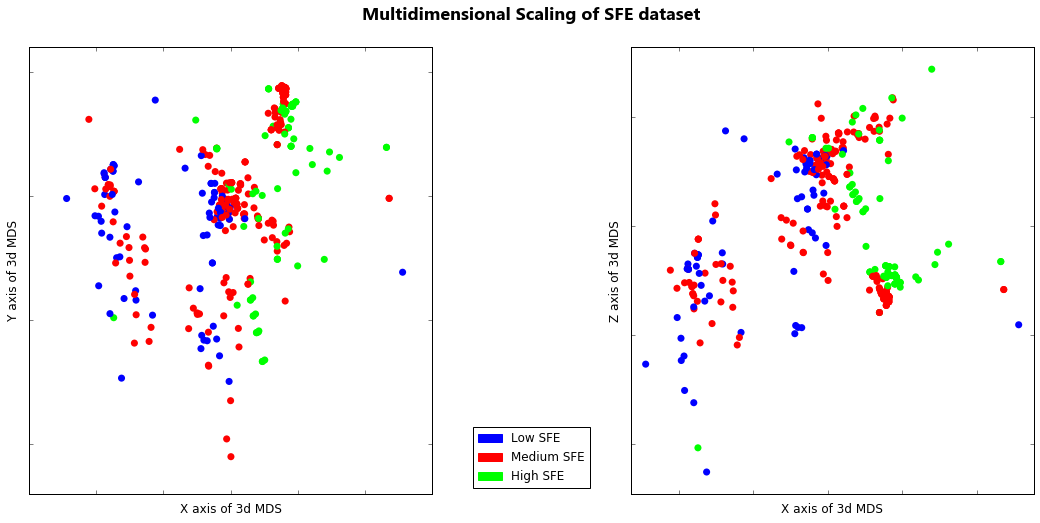

In [62]:
fig = plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(10, 3,width_ratios=[10,2,10])
#fig.suptitle("Multidimensional Scaling of SFE Dataset", fontweight='bold', fontsize=18, fontname='Segoe UI')
#plt.subplots_adjust(top=.95)

ax1 = plt.subplot(gs[:10,0])
ax2 = plt.subplot(gs[:10,1],frameon=False)
ax3 = plt.subplot(gs[:10,2])

ax1.scatter( mds3NormY[:, 0], mds3NormY[:, 1], c = SFEclass, s =50,  edgecolor='', cmap='brg')
ax1.set_xlabel("X axis of 3d MDS", fontsize=12)
ax1.set_ylabel("Y axis of 3d MDS", fontsize=12)
ax3.set_xlim(mds3NormY[:,0].min()-0.1,mds3NormY[:,0].max()+0.1)
ax3.set_ylim(mds3NormY[:,1].min()-0.1,mds3NormY[:,1].max()+0.1)
#ax1.set_title("3 dimensional view", fontweight='normal', fontsize=15, fontname='Segoe UI')
#ax1.title.set_position([0.5,0.05])
ax1.xaxis.set_major_formatter(NullFormatter())
ax1.yaxis.set_major_formatter(NullFormatter())




ax3.scatter( mds3NormY[:, 0], mds3NormY[:, 2], c = SFEclass, s =50,  edgecolor='', cmap='brg')
ax3.set_xlabel("X axis of 3d MDS", fontsize=12)
ax3.set_ylabel("Z axis of 3d MDS", fontsize=12)
ax3.set_xlim(mds3NormY[:,0].min()-0.1,mds3NormY[:,0].max()+0.1)
ax3.set_ylim(mds3NormY[:,2].min()-0.1,mds3NormY[:,2].max()+0.1)
#ax3.set_title("2 dimensional view", fontweight='normal', fontsize=15, fontname='Segoe UI')
#ax3.title.set_position([0.5,-0.1])
ax3.xaxis.set_major_formatter(NullFormatter())
ax3.yaxis.set_major_formatter(NullFormatter())
#ax3.zaxis.set_major_formatter(NullFormatter())
#fig.colorbar(cax)

blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')

ax2.set_title("Multidimensional Scaling of SFE dataset", fontweight='heavy', fontsize=18, fontname='Segoe UI')
ax2.title.set_position([0.5,1.05])
ax2.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower center')
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

#plt.savefig('MDS2.png',dpi=500)
plt.show()

In [129]:
## sandbox cell for checking values from MDS
checkarray = np.where((mds3NormY[:,0]>0.2)&(mds3NormY[:,2]<-0.2))
print checkarray
print ini_dataset_5.iloc[checkarray]
print mds3NormY[65,:]

(array([257, 284, 285, 286, 287, 290, 291, 292, 293, 294, 295, 296, 297,
       298, 299, 300, 301, 302, 303, 304, 305, 307, 308, 309, 310, 311,
       312, 313, 315, 316, 318, 319, 320, 321, 322, 323, 324, 325, 326,
       327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
       340, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353,
       354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366,
       367, 368, 369, 370, 371, 372], dtype=int64),)
          C       N     Ni  Al       Fe    Mo    Mn     Si     Cr   SFE  \
sno                                                                       
258  0.0550  0.0000  13.01   0  65.7300  2.09  1.40  0.530  17.15  78.0   
285  0.0040  0.0030  15.60   0  64.3170  2.50  0.03  0.020  17.50  49.6   
286  0.0200  0.0090  15.60   0  64.1880  2.50  0.03  0.030  17.60  50.8   
287  0.0200  0.0020  14.00   0  66.4090  2.40  0.03  0.010  17.10  46.6   
288  0.0050  0.0010  15.60   0  63.8660  2.60  0.19  0.010  17.7

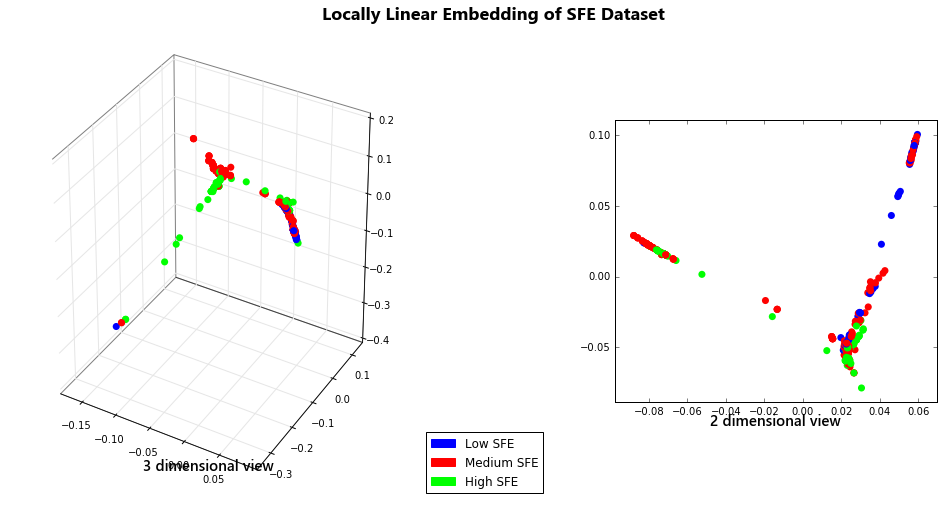

In [69]:
n_neighbors = 20


LLEY_3 = manifold.LocallyLinearEmbedding(n_neighbors, n_components=3,
                                        eigen_solver='dense',
                                        method='modified').fit_transform(NormElements)

LLEY_2 = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                        eigen_solver='dense',
                                        method='modified').fit_transform(NormElements)

fig = plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(10, 5,width_ratios=[10,2,.5,8,1])
fig.suptitle("Locally Linear Embedding of SFE Dataset", fontweight='bold', fontsize=18, fontname='Segoe UI')
plt.subplots_adjust(top=.95)

ax1 = plt.subplot(gs[:10,0], projection='3d')
ax2 = plt.subplot(gs[:10,1],frameon=False)
ax3 = plt.subplot(gs[2:8,3])

ax1.scatter( LLEY_3[:, 0], LLEY_3[:, 1], LLEY_3[:, 2], c = SFEclass, s =50,  edgecolor='', depthshade=False, cmap='brg')
ax1.set_title("3 dimensional view", fontweight='normal', fontsize=15, fontname='Segoe UI')
ax1.title.set_position([0.5,0.05])
ax1.set_xlim(LLEY_3[:,0].min()-0.01,LLEY_3[:,0].max()+0.01)
ax1.set_ylim(LLEY_3[:,1].min()-0.01,LLEY_3[:,1].max()+0.01)
ax1.set_ylim(LLEY_3[:,2].min()-0.01,LLEY_3[:,2].max()+0.01)
#ax1.xaxis.set_major_formatter(NullFormatter())
#ax1.zaxis.set_major_formatter(NullFormatter())
#ax1.view_init(15,120)
ax1.xaxis.pane.set_edgecolor('black')
ax1.yaxis.pane.set_edgecolor('black')
ax1.zaxis.pane.set_edgecolor('black')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False



ax3.scatter(LLEY_2[:, 0], LLEY_2[:, 1], c = SFEclass, s =50,  edgecolor='', cmap='brg')
ax3.set_xlim(LLEY_2[:,0].min()-0.01,LLEY_2[:,0].max()+0.01)
ax3.set_ylim(LLEY_2[:,1].min()-0.01,LLEY_2[:,1].max()+0.01)
ax3.set_title("2 dimensional view", fontweight='normal', fontsize=15, fontname='Segoe UI')
ax3.title.set_position([0.5,-0.1])
#ax3.xaxis.set_major_formatter(NullFormatter())
#ax3.yaxis.set_major_formatter(NullFormatter())
#ax3.zaxis.set_major_formatter(NullFormatter())
#fig.colorbar(cax)

blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')

#ax2.set_title("Multidimensional Scaling of SFE dataset", fontweight='heavy', fontsize=18, fontname='Segoe UI')
#ax2.title.set_position([0.5,1.05])
ax2.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower center')
#ax2.xaxis.set_major_formatter(plt.NullFormatter())
#ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

#plt.savefig('LLE.png',dpi=500)
plt.show()



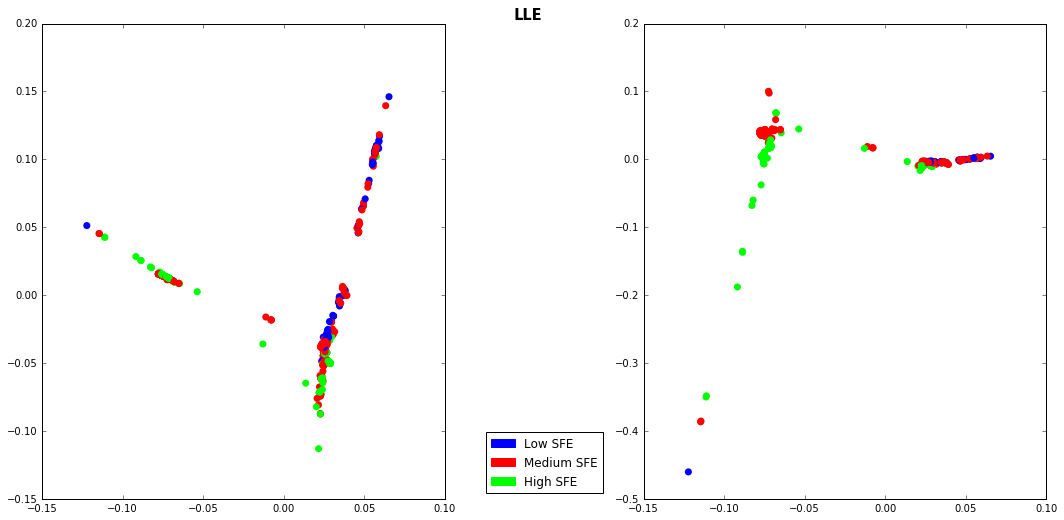

In [65]:
fig = plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(10, 3,width_ratios=[10,2,10])
fig.suptitle("LLE", fontweight='bold', fontsize=18, fontname='Segoe UI')
plt.subplots_adjust(top=.95)

ax1 = plt.subplot(gs[:10,0])
ax2 = plt.subplot(gs[:10,1],frameon=False)
ax3 = plt.subplot(gs[:10,2])

ax1.scatter( LLEY_3[:, 0], LLEY_3[:, 1], c = SFEclass, s =50,  edgecolor='', cmap='brg')
#ax1.set_title("3 dimensional view", fontweight='normal', fontsize=15, fontname='Segoe UI')
#ax1.title.set_position([0.5,0.05])
#ax1.xaxis.set_major_formatter(NullFormatter())
#ax1.yaxis.set_major_formatter(NullFormatter())




ax3.scatter( LLEY_3[:, 0], LLEY_3[:, 2], c = SFEclass, s =50,  edgecolor='', cmap='brg')
#ax3.set_xlim(mds3NormY[:,0].min()-0.1,mds3NormY[:,0].max()+0.1)
#ax3.set_ylim(mds3NormY[:,2].min()-0.1,mds3NormY[:,2].max()+0.1)
#ax3.set_title("2 dimensional view", fontweight='normal', fontsize=15, fontname='Segoe UI')
#ax3.title.set_position([0.5,-0.1])
#ax3.xaxis.set_major_formatter(NullFormatter())
#ax3.yaxis.set_major_formatter(NullFormatter())
#ax3.zaxis.set_major_formatter(NullFormatter())
#fig.colorbar(cax)

blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')

#ax2.set_title("Multidimensional Scaling of SFE dataset", fontweight='heavy', fontsize=18, fontname='Segoe UI')
#ax2.title.set_position([0.5,1.05])
ax2.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower center')
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

plt.show()

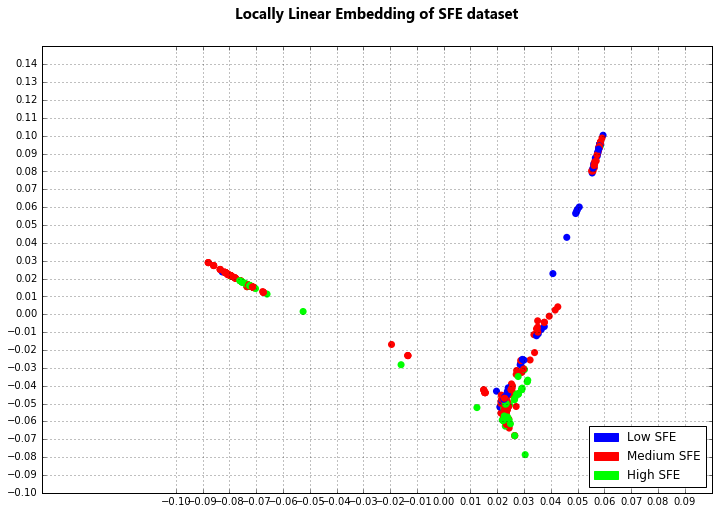

In [70]:
fig = plt.figure(figsize= (12,8))
ax= fig.add_subplot(1,1,1)
ax.scatter( LLEY_2[:, 0], LLEY_2[:, 1], c = SFEclass, s =50,  edgecolor='', cmap='brg' )
ax.set_xticks(np.arange(-0.1,0.1,0.01))
ax.set_yticks(np.arange(-0.1,0.15,0.01))
ax.grid(True)
#ax.set_xlim(LLEY_2[:,0].min()-0.01,LLEY_2[:,0].max()+0.01)
#ax.set_ylim(LLEY_2[:,1].min()-0.01,LLEY_2[:,1].max()+0.01)
#ax.xaxis.set_major_formatter(NullFormatter())
#ax.yaxis.set_major_formatter(NullFormatter())
blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')
ax.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower right')
ax.set_title("Locally Linear Embedding of SFE dataset", fontweight='bold', fontsize=15, fontname='Segoe UI')
ax.title.set_position([0.5,1.05])

#plt.savefig('LLE.png',dpi=500)
plt.show()

In [257]:
LLEY_2[97]

array([-0.01006319, -0.05374074])

In [227]:
## sandbox cell for checking values from MDS
checkarray = np.where((LLEY_2[:,0]<-0.007)&(LLEY_2[:,1]>-0.055))
print checkarray
print ini_dataset_5.iloc[checkarray]
LLEY_2[37]

(array([ 33,  34,  35,  36,  37,  39,  40,  43,  44,  51,  52,  53,  56,
        57,  58,  59,  60,  61,  62,  66,  75,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       120, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 163, 164, 165,
       166, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209,
       210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
       223, 224, 225, 226, 227, 228, 231, 232, 233, 234, 235, 236, 237,
       238, 239, 240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 258, 259, 261, 262, 263, 264, 265, 2

array([-0.07654921,  0.07973675])

In [171]:
print ini_dataset_5.iloc[[37,57,88,172,178,179,180,181,219,220,221,222,223,234,235,236,237,246,256,258,267,269,283]]

         C      N     Ni    Al      Fe    Mo      Mn    Si     Cr    SFE  \
sno                                                                        
38   0.660  0.000   0.00  9.77  65.540  0.00  23.780  0.00   0.00  54.74   
58   0.033  0.210   7.58  0.00  64.718  0.00   8.430  0.17  18.80  53.00   
89   0.280  0.000   0.00  3.98  70.770  0.00  20.100  0.00   4.87  47.50   
173  0.030  0.398  16.30  0.00  54.698  0.00   9.640  0.45  18.48  73.00   
179  0.070  0.210  16.13  0.00  54.900  0.00   9.640  0.45  18.48  54.00   
180  0.070  0.310  16.13  0.00  54.800  0.00   9.640  0.45  18.48  62.00   
181  0.070  0.400  16.13  0.00  54.710  0.00   9.640  0.45  18.48  65.00   
182  0.070  0.540  16.13  0.00  54.570  0.00   9.640  0.45  18.48  52.00   
220  0.000  0.070  16.10  0.00  55.730  0.00   9.600  0.00  18.50  46.80   
221  0.000  0.210  16.10  0.00  55.590  0.00   9.600  0.00  18.50  54.90   
222  0.000  0.310  16.10  0.00  55.490  0.00   9.600  0.00  18.50  62.10   
223  0.000  

In [ ]:
LLEY_2[256,:]

Doing changes to the dataset as prescribed by visualization 

In [29]:
SFEclass3 = SFEclass

In [30]:
print SFEclass [[54,57,88,246,283]]

[ 1.  3.  3.  3.  3.]


In [31]:
SFEclass3[[54,57,88,246,283]]=[2.,2.,2.,2.,2.]

## Classification

Lot of stuff tried down here to get the best model

In [130]:
#defining master indices
master_indices = np.arange(NormElements.shape[0])
print 'master indices shape : ', master_indices.shape

#choosing test set and corressponding training set
np.random.seed(20)
test_prop = 0.2
test_indices = np.random.choice(NormElements.shape[0],int(math.floor(test_prop*NormElements.shape[0])),replace = False)
test_x = NormElements[test_indices]
test_y = SFEclass[test_indices]

train_indices = master_indices
print 'train indices shape :', train_indices.shape
for item in test_indices:
    train_indices = np.delete(train_indices,np.where(train_indices==item))
print 'train indices shape  :', train_indices.shape

train_x = NormElements[train_indices]
train_y = SFEclass[train_indices]

master indices shape :  (374L,)
train indices shape : (374L,)
train indices shape  : (300L,)


In [46]:
print "1",(SFEclass[train_indices,]==1).sum(),np.true_divide((SFEclass[train_indices,]==1).sum(),300)
print "3",(SFEclass[train_indices,]==2).sum(),np.true_divide((SFEclass[train_indices,]==2).sum(),300)
print "3",(SFEclass[train_indices,]==3).sum(),np.true_divide((SFEclass[train_indices,]==3).sum(),300)

1 59 0.196666666667
3 167 0.556666666667
3 74 0.246666666667


Support Vector Machines

In [40]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

C_range = np.logspace(-2, 10, 10, base=2)
gamma_range = np.logspace(-9, 1, 5, base=2)
k_options = ['linear','poly','rbf']
params_grids = dict(gamma=gamma_range, C=C_range, kernel=k_options)
grid = GridSearchCV(SVC(), param_grid=params_grids, cv=30, n_jobs=10)
grid.fit(train_x,train_y)

print grid.best_params_
grid.grid_scores_

{'kernel': 'poly', 'C': 1.5874010519681994, 'gamma': 2.0}


[mean: 0.54000, std: 0.07227, params: {'kernel': 'linear', 'C': 0.25, 'gamma': 0.001953125},
 mean: 0.55667, std: 0.02004, params: {'kernel': 'poly', 'C': 0.25, 'gamma': 0.001953125},
 mean: 0.55667, std: 0.02004, params: {'kernel': 'rbf', 'C': 0.25, 'gamma': 0.001953125},
 mean: 0.54000, std: 0.07227, params: {'kernel': 'linear', 'C': 0.25, 'gamma': 0.011048543456039806},
 mean: 0.55667, std: 0.02004, params: {'kernel': 'poly', 'C': 0.25, 'gamma': 0.011048543456039806},
 mean: 0.55667, std: 0.02004, params: {'kernel': 'rbf', 'C': 0.25, 'gamma': 0.011048543456039806},
 mean: 0.54000, std: 0.07227, params: {'kernel': 'linear', 'C': 0.25, 'gamma': 0.0625},
 mean: 0.55667, std: 0.02004, params: {'kernel': 'poly', 'C': 0.25, 'gamma': 0.0625},
 mean: 0.55667, std: 0.02004, params: {'kernel': 'rbf', 'C': 0.25, 'gamma': 0.0625},
 mean: 0.54000, std: 0.07227, params: {'kernel': 'linear', 'C': 0.25, 'gamma': 0.35355339059327379},
 mean: 0.55667, std: 0.02004, params: {'kernel': 'poly', 'C': 0.2

In [57]:
clf_svc= SVC(kernel= 'poly', C= 1.58, gamma = 2.0, random_state=25)
clf_svc.fit(train_x, train_y)
predict_y_svc = clf_svc.predict(test_x)


from sklearn import metrics
model_score = clf_svc.score(test_x, test_y)
print ("Model Score for SVM on actual Data %.2f \n" % (model_score))

train_score = clf_svc.score(train_x, train_y)
print ("Model Score for SVM on training Data %.2f \n" % (train_score))

Model Score for SVM on actual Data 0.88 

Model Score for SVM on training Data 0.83 



In [51]:
from sklearn.metrics import confusion_matrix
cm_svc = confusion_matrix(test_y,predict_y_svc)
print confusion_matrix(test_y,predict_y_svc)

from sklearn.metrics import precision_score
print precision_score(test_y,predict_y_svc,average=None)

from sklearn.metrics import recall_score
print recall_score(test_y,predict_y_svc,average=None)

from sklearn.metrics import precision_score
print precision_score(test_y,predict_y_svc,average='macro')

from sklearn.metrics import recall_score
print recall_score(test_y,predict_y_svc,average='macro')


[[13  5  0]
 [ 1 38  3]
 [ 1  3 10]]
[ 0.86666667  0.82608696  0.76923077]
[ 0.72222222  0.9047619   0.71428571]
0.82066146414
0.780423280423


In [467]:
np.true_divide(cm_svc,74)*100


array([[ 17.56756757,   6.75675676,   0.        ],
       [  0.        ,  52.7027027 ,   4.05405405],
       [  1.35135135,   4.05405405,  13.51351351]])

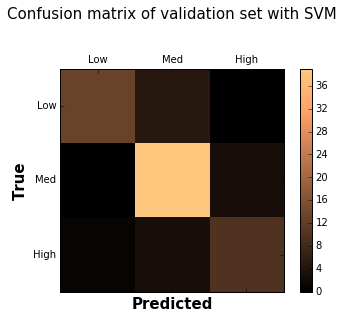

In [513]:
labels = ['Low', 'Med', 'High']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svc, cmap=plt.get_cmap('copper'))
ax.set_title('Confusion matrix of validation set with SVM', fontsize=15, x=0.5, y=1.2)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted', fontsize=15, fontweight = 'bold')
plt.ylabel('True', fontsize=15,  fontweight = 'bold')
plt.savefig("CM_SVC.png",format ='png', dpi=500, bbox_inches='tight',orientation='landscape')
plt.show()

Random Forests

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

param_grid =  { "n_estimators" :[10,20,30,40,50],
                "max_features": [3,4,5]}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=30, n_jobs=10)
grid_search.fit(train_x,train_y)

print grid_search.best_params_
grid_search.grid_scores_

{'max_features': 5, 'n_estimators': 30}


[mean: 0.74667, std: 0.18651, params: {'max_features': 3, 'n_estimators': 10},
 mean: 0.75333, std: 0.20177, params: {'max_features': 3, 'n_estimators': 20},
 mean: 0.76333, std: 0.18175, params: {'max_features': 3, 'n_estimators': 30},
 mean: 0.76000, std: 0.19677, params: {'max_features': 3, 'n_estimators': 40},
 mean: 0.78333, std: 0.17857, params: {'max_features': 3, 'n_estimators': 50},
 mean: 0.76667, std: 0.18489, params: {'max_features': 4, 'n_estimators': 10},
 mean: 0.77333, std: 0.16162, params: {'max_features': 4, 'n_estimators': 20},
 mean: 0.77333, std: 0.17938, params: {'max_features': 4, 'n_estimators': 30},
 mean: 0.76333, std: 0.17120, params: {'max_features': 4, 'n_estimators': 40},
 mean: 0.77333, std: 0.16144, params: {'max_features': 4, 'n_estimators': 50},
 mean: 0.76667, std: 0.18730, params: {'max_features': 5, 'n_estimators': 10},
 mean: 0.76333, std: 0.17968, params: {'max_features': 5, 'n_estimators': 20},
 mean: 0.80000, std: 0.15721, params: {'max_features

In [187]:
clf_rf = RandomForestClassifier(n_estimators=30,max_features=5,criterion='entropy', random_state=25, oob_score=True)
clf_rf.fit(train_x, train_y)
predict_y_rf = clf_rf.predict(test_x)
predict_y_rf_prob = clf_rf.predict_proba(test_x)

from sklearn import metrics
model_score = clf_rf.score(test_x, test_y)
print ("Model Score for RF on actual Data %.2f \n" % (model_score))

train_score = clf_rf.score(train_x, train_y)
print ("Model Score for RF on training Data %.2f \n" % (train_score))

Model Score for RF on actual Data 0.86 

Model Score for RF on training Data 0.99 



In [189]:
clf_rf.oob_score_

0.7466666666666667

In [120]:
print clf_rf.feature_importances_

from sklearn.metrics import confusion_matrix
cm_rf = confusion_matrix(test_y,predict_y_rf)
print confusion_matrix(test_y,predict_y_rf)

from sklearn.metrics import precision_score
print precision_score(test_y,predict_y_rf,average=None)

from sklearn.metrics import recall_score
print recall_score(test_y,predict_y_rf,average=None)

from sklearn.metrics import precision_score
print precision_score(test_y,predict_y_rf,average='macro')

from sklearn.metrics import recall_score
print recall_score(test_y,predict_y_rf,average='macro')



[ 0.08833242  0.08563014  0.27409262  0.02979945  0.2223001   0.0647517
  0.09797655  0.05855148  0.07856555]
[[12  4  0]
 [ 3 39  1]
 [ 0  2 13]]
[ 0.8         0.86666667  0.92857143]
[ 0.75        0.90697674  0.86666667]
0.865079365079
0.841214470284


In [476]:
np.true_divide(cm_rf,74)*100

array([[ 20.27027027,   4.05405405,   0.        ],
       [  1.35135135,  51.35135135,   4.05405405],
       [  1.35135135,   4.05405405,  13.51351351]])

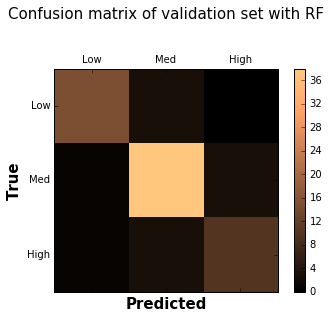

In [514]:
labels = ['Low', 'Med', 'High']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_rf, cmap=plt.get_cmap('copper'))
ax.set_title('Confusion matrix of validation set with RF', fontsize=15, x=0.5, y=1.2)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted', fontsize=15, fontweight = 'bold')
plt.ylabel('True', fontsize=15,  fontweight = 'bold')
plt.savefig("CM_RF.png",format ='png', dpi=500, bbox_inches='tight',orientation='landscape')
plt.show()

In [182]:
def custom_predict(predicted_prob):
    custom_prediction_array = np.zeros(predicted_prob.shape[0])
    
    for i in range(0,predicted_prob.shape[0]):
                    
        for j in range(0,3):
            if predicted_prob[i,j] > 0.66:
                custom_prediction_array[i] = j+1
            
        if custom_prediction_array[i] == 0:
            if (predicted_prob[i,0]+predicted_prob[i,1]) > 0.7:
                custom_prediction_array[i] = 4
            elif (predicted_prob[i,1]+predicted_prob[i,2]) > 0.7:
                custom_prediction_array[i] = 5
            else:
                custom_prediction_array[i] = 0
        
    
    return custom_prediction_array

In [183]:
cust_pred_y_rf = custom_predict(predict_y_rf_prob)

In [176]:
def custom_cm_custpred(testy,customprediction):
    
    cm = np.zeros((3,5))
  
    
    for m in range(0,testy.shape[0]):
        i = testy[m]
        j = customprediction[m]
        cm[i-1,j-1] = cm[i-1,j-1] + 1
    
    
    return cm


In [171]:
SFE = SFEdata[:,10]

In [184]:
custom_cm_rf = custom_cm_custpred(test_y,cust_pred_y_rf)
custom_cm_rf

C:\Users\Nayan\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([[  7.,   3.,   0.,   6.,   0.],
       [  2.,  31.,   1.,   8.,   1.],
       [  0.,   1.,  12.,   0.,   2.]])

In [100]:
def output_custom_metrics(custom_cm):
    
    nr = np.true_divide(float(np.sum(custom_cm[:,3:5])),np.sum(custom_cm))
    correct = custom_cm[0,0] + custom_cm[1,1] + custom_cm[2,2] + np.sum(custom_cm[0:2,3]) + np.sum(custom_cm[1:3,4])
    safe = np.true_divide(float(correct),np.sum(custom_cm))
    
    return [nr,safe]

In [178]:
output_custom_metrics(custom_cm_rf)

[0.027027027027027029, 0.86486486486486491]

In [206]:
incorr = test_indices[test_y!=predict_y_rf]
incorr = incorr.tolist()

In [208]:
ini_dataset_5.iloc[incorr]

,C,N,Ni,Al,Fe,Mo,Mn,Si,Cr,SFE,Error,title,Author,temperature,experiment_type
sno,,,,,,,,,,,,,,,
57,0.048,0.325,20.10,0,53.377,0.00,0.84,0.31,25.00,42.90,0.000000,Weak Beam TEM Study on Stacking Fault Energy o...,"Ojima, M.",300,TEM
207,0.000,0.000,11.00,0,71.700,0.00,0.00,0.00,17.30,18.00,0.000000,The formation of Hcp and Bcc phases in austeni...,"Breedis, J.F.",300,TEM
206,0.000,0.000,11.20,0,69.500,0.00,0.00,0.00,19.30,13.00,0.000000,The formation of Hcp and Bcc phases in austeni...,"Breedis, J.F.",300,TEM
199,0.030,0.690,0.00,0,72.470,0.00,9.82,0.17,17.54,22.80,0.021930,Correlation between stacking fault energy and ...,"Lee, Tae-Ho",300,Neutron Diffraction
205,0.130,0.000,11.16,0,69.280,0.00,0.47,1.06,17.90,17.25,0.066700,Influence of solute additions on the stacking ...,"Dulieu, D.",300,TEM
201,0.380,0.380,0.00,0,72.000,0.00,9.66,0.22,18.12,27.60,0.014493,Correlation between stacking fault energy and ...,"Lee, Tae-Ho",300,Neutron Diffraction
269,0.007,0.006,23.00,0,61.127,0.00,0.04,0.00,15.80,64.40,0.000000,Twin frequency and stacking fault energy in au...,"Silcock, J.M.",300,TEM
93,0.030,0.010,5.90,0,69.650,0.01,7.10,1.10,16.20,17.50,0.080000,Stacking fault energy in austenitic steels det...,"Rafaja, D.",300,XRD
259,0.027,0.310,7.11,0,62.329,0.03,8.75,0.43,21.00,65.00,0.184615,Stacking fault energies of seven commercial au...,"Schramm, R.E.",300,XRD


**Trying to calibrate random forest using this metric**

In [113]:
from sklearn.cross_validation import KFold

kf = KFold(train_x.shape[0], n_folds=15, shuffle=True)


num_trees = [10,20,30,40,50]
num_esti = [3,4,5]

for item in num_trees:
    for item1 in num_esti:
        clf_rf_try = RandomForestClassifier(n_estimators= item, max_features= item1, criterion='entropy', random_state=25)
        
        counter = 0
        safe_scores = np.zeros((15,))
        nr_scores = np.zeros((15,))
        
        for train_index_custcv, test_index_custcv in kf:
            print "this is run %d"%(counter+1)
            custcv_train_x, custcv_test_x = train_x[train_index_custcv] , train_x[test_index_custcv]
            custcv_train_y, custcv_test_y = train_y[train_index_custcv] , train_y[test_index_custcv]
            
            clf_rf_try.fit(custcv_train_x, custcv_train_y)
            predict_custcv_y_rf = clf_rf_try.predict(custcv_test_x)
            predict_custcv_y_rf_prob = clf_rf_try.predict_proba(custcv_test_x)
            
            custcv_cust_pred_y_rf = custom_predict(predict_custcv_y_rf_prob)
            custcv_custom_cm_rf = custom_cm_custpred(SFEclass,test_index_custcv,custcv_cust_pred_y_rf)
            
            print custcv_test_y
            print custcv_cust_pred_y_rf
            print predict_custcv_y_rf_prob
            print custcv_cust_pred_y_rf
            print confusion_matrix(custcv_test_y,predict_custcv_y_rf)
            print custcv_custom_cm_rf
            
            safe_scores[counter] = output_custom_metrics(custcv_custom_cm_rf)[0]
            nr_scores[counter] = output_custom_metrics(custcv_custom_cm_rf)[1]
            counter = counter+1
            
        mean_safe_custcv = np.nanmean(safe_scores)
        mean_nr_custcv = np.nanmean(nr_scores) 
        
        print "Trees: %d , Esti:%d, safe: %f , nr: %f"% (item, item1, mean_safe_custcv, mean_nr_custcv)

this is run 1
[ 2.  2.  2.  2.  3.  2.  2.  3.  1.  1.  2.  1.  2.  3.  1.  1.  2.  3.
  3.  2.]
[ 2.  2.  2.  2.  3.  2.  2.  3.  1.  1.  4.  2.  2.  3.  1.  1.  2.  2.
  3.  5.]
[[ 0.   1.   0. ]
 [ 0.   1.   0. ]
 [ 0.   1.   0. ]
 [ 0.   1.   0. ]
 [ 0.   0.1  0.9]
 [ 0.   0.8  0.2]
 [ 0.   0.7  0.3]
 [ 0.   0.1  0.9]
 [ 1.   0.   0. ]
 [ 0.8  0.2  0. ]
 [ 0.5  0.4  0.1]
 [ 0.3  0.7  0. ]
 [ 0.   0.7  0.3]
 [ 0.   0.   1. ]
 [ 0.6  0.4  0. ]
 [ 0.7  0.3  0. ]
 [ 0.2  0.8  0. ]
 [ 0.   1.   0. ]
 [ 0.   0.1  0.9]
 [ 0.2  0.5  0.3]]
[ 2.  2.  2.  2.  3.  2.  2.  3.  1.  1.  4.  2.  2.  3.  1.  1.  2.  2.
  3.  5.]
[[4 1 0]
 [1 9 0]
 [0 1 4]]
[[ 1.  1.  1.  0.  0.]
 [ 3.  8.  3.  0.  0.]
 [ 0.  1.  0.  1.  1.]]
this is run 2
[ 3.  2.  2.  2.  3.  2.  2.  2.  1.  2.  1.  1.  1.  2.  2.  3.  2.  2.
  2.  2.]
[ 3.  5.  2.  2.  3.  2.  4.  4.  1.  2.  1.  2.  2.  2.  2.  3.  2.  2.
  2.  2.]
[[ 0.   0.   1. ]
 [ 0.   0.5  0.5]
 [ 0.1  0.9  0. ]
 [ 0.2  0.6  0.2]
 [ 0.   0.   1. ]
 [ 0.   

C:\Users\Nayan\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Artificial Neural Net Metrics

In [482]:
cm_ann = [[12,6,0],
          [0,39,3],
          [1,2,11]]
cm_ann

[[12, 6, 0], [0, 39, 3], [1, 2, 11]]

In [483]:
np.true_divide(cm_ann,74)*100

array([[ 16.21621622,   8.10810811,   0.        ],
       [  0.        ,  52.7027027 ,   4.05405405],
       [  1.35135135,   2.7027027 ,  14.86486486]])

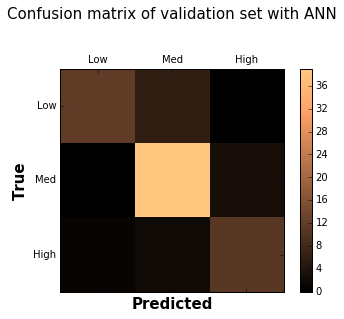

In [512]:
labels = ['Low', 'Med', 'High']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_ann, cmap=plt.get_cmap('copper'))
ax.set_title('Confusion matrix of validation set with ANN', fontsize=15, x=0.5, y=1.2)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted', fontsize=15, fontweight = 'bold')
plt.ylabel('True', fontsize=15,  fontweight = 'bold')
plt.savefig("CM_ANN.png",format ='png', dpi=500, bbox_inches='tight',orientation='landscape')
plt.show()

In [362]:
ini_dataset_5.to_csv('csvtry.csv',header=True,index=True)


In [364]:
np.savetxt('train_x.txt',train_x)
np.savetxt('train_y.txt',train_y)
np.savetxt('test_x.txt', test_x)
np.savetxt('test_y.txt', test_y)
np.savetxt('train_indices.txt',train_indices)
np.savetxt('test_indices.txt',test_indices)


## Knowledge accusition from modelling

In [81]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
normele = min_max_scaler.fit_transform(Elements[:,1:])

In [82]:
print min_max_scaler.data_max_
print min_max_scaler.data_min_
print min_max_scaler.data_range_

[  0.96   0.88  40.     9.77  85.     3.    32.55   8.67  30.  ]
[  0.    0.    0.    0.   38.3   0.    0.    0.    0. ]
[  0.96   0.88  40.     9.77  46.7    3.    32.55   8.67  30.  ]


In [83]:
def predict_everything(test):
    norm_test = min_max_scaler.transform(test)
    predict_test = clf_rf.predict(norm_test)
    predict_test_prob = clf_rf.predict_proba(norm_test)
    predict_test_custom = custom_predict(predict_test_prob)
    
    return predict_test_custom

In [532]:
Elementlist

array(['C', 'N', 'Ni', 'Al', 'Fe', 'Mo', 'Mn', 'Si', 'Cr'], dtype=object)

In [85]:
raabe = [[0.0 , 0.0 , 0.0 , 0.0, 40.32, 0.0, 39.66, 0.0, 9.38]]
predict_everything(raabe)

array([ 4.])

In [86]:
zaddach = [[0.0 , 0.0 , 26.03 , 0.0, 24.77, 0.0, 0.0, 0.0, 23.06],
          [0.0 , 0.0 , 20.93 , 0.0, 19.92, 0.0, 19.59, 0.0, 18.54]]

predict_everything(zaddach)

array([ 4.,  4.])

In [538]:
zaddach1 = [[0.0 , 0.0 , 27.02 , 0.0, 19.77, 0.0, 19.45, 0.0, 12.89],
            [0.0 , 0.0 , 23.99 , 0.0, 19.84, 0.0, 19.52, 0.0, 15.71],
            [0.0 , 0.0 , 14.76 , 0.0, 20.06, 0.0, 19.73, 0.0, 24.28],
            [0.0 , 0.0 , 14.7 , 0.0, 21.48, 0.0, 21.14, 0.0, 20.00]]
predict_everything(zaddach1)

array([ 5.,  5.,  4.,  4.])

In [545]:
sato = [[0.0 , 0.0 , 0.0, 0.00 , 79.40, 0.0, 20.60, 0.0, 0],
        [0.0 , 0.0 , 0.0, 1.81 , 79.10, 0.0, 19.10, 0.0, 0],
        [0.0 , 0.0 , 0.0, 4.40 , 76.20, 0.0, 19.40, 0.0, 0],
        [0.0 , 0.0 , 0.0, 5.70 , 73.40, 0.0, 20.60, 0.0, 0],
        [0.0 , 0.0 , 0.0, 0.00 , 68.70, 0.0, 31.30, 0.0, 0],
        [0.0 , 0.0 , 0.0, 2.05 , 68.80, 0.0, 29.14, 0.0, 0],
        [0.0 , 0.0 , 0.0, 3.81 , 67.00, 0.0, 29.18, 0.0, 0],
        [0.0 , 0.0 , 0.0, 7.15 , 64.00, 0.0, 28.80, 0.0, 0]]


predict_everything(sato)

array([ 1.,  2.,  2.,  4.,  2.,  2.,  2.,  4.])

In [557]:
curtze =[[0.08 , 0.0 , 0 , 1.60, 70.04, 0.0, 28, 0.28, 12.89],
         [0.08 , 0.0 , 0 , 1.60, 73.08, 0.0, 25, 0.24, 15.71],
         [0.08 , 0.0 , 0 , 4.10, 68.30, 0.0, 27, 0.52, 24.28]]

predict_everything(curtze)

array([ 4.,  4.,  2.])

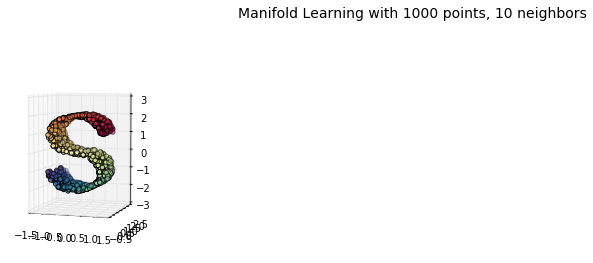

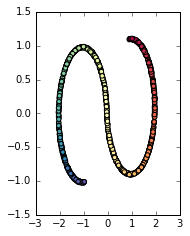

In [196]:
from time import time

#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(251, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
except:
    ax = fig.add_subplot(251, projection='3d')
    plt.scatter(X[:, 0], X[:, 2], c=color, cmap=plt.cm.Spectral)

    
from sklearn.decomposition import PCA
pca_2 = PCA(n_components=2)
try_pca = pca_2.fit_transform(X)
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(2,5,1)
plt.scatter(try_pca[:, 0], try_pca[:, 1], c=color, cmap=plt.cm.Spectral)
